In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v79)
suppressMessages(library(dplyr))
library('Matrix')
set.seed(1)

library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(cowplot)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The

In [2]:
#### set enviroment
home = '~/farm/endometrium/data/scATAC/'
setwd(home)
outdir = paste0(home, 'seurat.output-S2D19/')
system(paste0('mkdir -p ', outdir, '/data'))
system(paste0('mkdir -p ', outdir, '/general'))
system(paste0('mkdir -p ', outdir, '/clusters/DAGenes'))


cellatac_dir = '/warehouse/cellgeni/tic-564/results50k_s2/'
fragments_dir = '/nfs/team292/lg18/endometrium/data/scATACseq/roser_paper/fragmentsALL_s2/'
#### 


In [3]:
### Load data
so = readRDS(file = paste0(outdir, '/data/M0_preintegration_noclipped.rds'))

# Gene activity matrix

Quantify the activity of each gene in the genome by assessing the chromatin accessibility associated with each gene. Signat uses a simple approach of summing the reads intersecting the gene body and promoter region

To create a gene activity matrix:


In [4]:
# 1. extract gene coordinates for the human genome from EnsembleDB
# extract gene coordinates from Ensembl, and ensure name formatting is consistent with Seurat object
gene.coords <- genes(EnsDb.Hsapiens.v79, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(gene.coords) <- 'UCSC'
genebody.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')

In [5]:
# 2. extend them to include the 2kb upstream region
genebodyandpromoter.coords <- Extend(x = gene.coords, upstream = 1200, downstream = 200)

In [ ]:
# 3. count the number of fragments for each cell that map to each of these regions ---FeatureMatrix function.
#    This takes any set of genomic coordinates,
#    counts the number of reads intersecting these coordinates in each cell,
#    and returns a sparse matrix.
# create a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = paste0(fragments_dir, 'fragments.tsv.gz'),
  features = genebodyandpromoter.coords,
  cells = colnames(so),
  chunk = 20
)

Extracting reads overlapping genomic regions



In [ ]:
# 4. convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- gene.key[rownames(gene.activities)]
# add the gene activity matrix to the Seurat object as a new assay, and normalize it
so[['RNA']] <- CreateAssayObject(counts = gene.activities)
so <- NormalizeData(
  object = so,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(so$nCount_RNA)
)

Do it in a cisTopic way

In [ ]:
# pred.matrix = so@assays$peaks@data

In [ ]:
# rownames(pred.matrix) = gsub('chr', '', rownames(pred.matrix))
# GR = genes(EnsDb.Hsapiens.v79)
# closest_genes_cl <- ClosestFeature(
#         regions = rownames(pred.matrix),
#         annotation = GR,
#         sep = c(':', '-'))

In [ ]:
# # Build Genes2Regions map
# closest_genes_cl = subset(closest_genes_cl, gene_biotype == 'protein_coding')
# closest_genes_cl = subset(closest_genes_cl, gene_name != '')
# geneRegionSets = lapply(unique(closest_genes_cl$gene_name), function(x) subset(closest_genes_cl, gene_name == x)$query_region  )
# names(geneRegionSets) = unique(closest_genes_cl$gene_name)

In [ ]:
# # Score genes my summing closest peak probabilities
# predMatSumByGene <- t(sapply(geneRegionSets, function(x) apply(pred.matrix[x,, drop=F], 2, sum)))

In [ ]:
# # add the gene activity matrix to the Seurat object as a new assay, and normalize it
# so[['RNA']] <- CreateAssayObject(counts = predMatSumByGene)
# so <- NormalizeData(
#   object = so,
#   assay = 'RNA',
#   normalization.method = 'LogNormalize',
#   scale.factor = median(so$nCount_RNA)
# )

## Save Gene scores

In [ ]:
saveRDS(so, file = paste0(outdir, '/data/M2_geneScores_noclipped.rds'))

In [ ]:
# so = readRDS(file = paste0(outdir, '/data/M2_geneScores_noclipped.rds'))

## Plot marker genes

In [ ]:
known_genes = c('TOP2A', 'PCNA', 'LGR6', 'KRT5',
           'SOX9', 'MMP7', 'WNT7A', 'KRT13',
           'PLAU',  'PLAUR', 'PGR', 'PAEP', 
           'SPP1', 'SCGB2A2', 'HEY1', 'SERPINA1', 
           'TP73', 'FOXJ1', 'PIFO', 'RSPH1')

In [ ]:
DefaultAssay(so) <- 'RNA'
FeaturePlot(
    object = so,
    features = known_genes,
    pt.size = 0.4,
    ncol = 4
  )
ggsave(filename = paste0(outdir, 'general/umap_markerGenes.pdf'), width = 17, height = 20)

In [ ]:
DefaultAssay(so) <- 'RNA'

#Alternative visualizations
VlnPlot(so, features = known_genes)
ggsave(device = 'pdf', file = paste0(outdir, '/general/boxplot_markerGenes.pdf'), width = 15, height = 25)

DotPlot(so, features = known_genes) + RotatedAxis()
ggsave(device = 'pdf', file = paste0(outdir, '/general/dotplot_markerGenes.pdf'), width = 8, height = 4)

DoHeatmap(subset(so, downsample = 100), features = known_genes, size = 3, slot = 'data')
ggsave(device = 'pdf', file = paste0(outdir, '/general/heatmap_markerGenes.pdf'), width = 8, height = 4)

In [ ]:
so@meta.data$sample_unique = paste(so@meta.data$donor, so@meta.data$sample)
# Compare donors
DotPlot(so, features = known_genes, group.by = 'sample_unique') + RotatedAxis()
ggsave(device = 'pdf', file = paste0(outdir, '/general/dotplot_markerGenes_perSample.pdf'), width = 8, height = 10)

VlnPlot(so, features = known_genes, group.by = 'sample_unique')
ggsave(device = 'pdf', file = paste0(outdir, '/general/boxplot_markerGenes_perSample.pdf'), width = 20, height = 25)


DoHeatmap(subset(so, downsample = 100), features = known_genes, size = 3, slot = 'data', group.by = 'sample_unique')
ggsave(device = 'pdf', file = paste0(outdir, '/general/heatmap_markerGenes_perSample.pdf'), width = 8, height = 10)

# Transfer scRNA labels

In [4]:
### Load scRNAseq processed data
rna = readRDS("~/farm/endometrium/data/scATAC/organoidsI_Donor19_scRNA_seuratobject.rds")

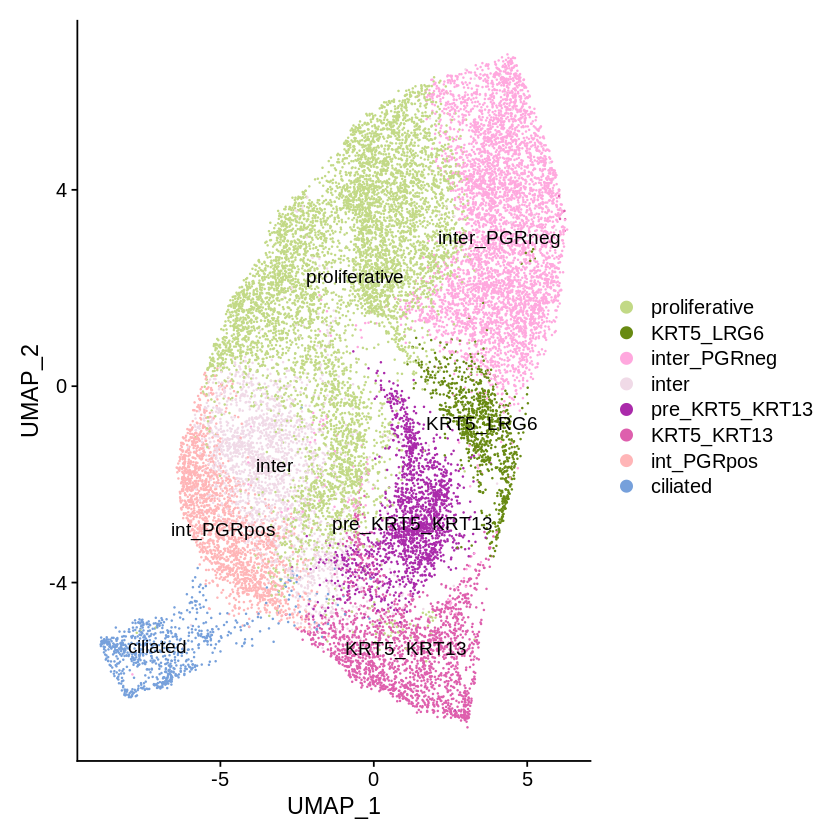

In [8]:
Idents(rna) = factor(Idents(rna) , levels = c('proliferative', 'KRT5_LRG6',  'inter_PGRneg', 'inter', 'pre_KRT5_KRT13', 'KRT5_KRT13', 
                                               'int_PGRpos','ciliated'))


colors = c('ciliated'='#76a0db',
           'int_PGRpos'='#ffb5b7',
           'KRT5_KRT13'='#de5fad',
           'pre_KRT5_KRT13'='#aa2aaa',
           'inter'= '#f0dae7',
           'inter_PGRneg'='#ffa8de',
           'KRT5_LRG6'= '#688a12',
           'proliferative'='#c2d986')

DimPlot(rna, reduction = "umap", label = T, cols = colors)
ggsave(device = 'pdf', file = paste0(outdir, '/general/umap_rna.pdf'), width = 6, height = 6)

In [7]:
rna

An object of class Seurat 
2201 features across 20411 samples within 1 assay 
Active assay: RNA (2201 features, 2201 variable features)
 2 dimensional reductions calculated: pca, umap

In [ ]:
so <- FindVariableFeatures(object = so, assay = 'RNA', selection.method = "vst", nfeatures = 2000, verbose = FALSE)

### Integrate and Transfer
rna$celltype = rna@meta.data$clusters
transfer.anchors <- FindTransferAnchors(
  reference = rna,
  query = so,
  reduction = 'cca'
)
predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = Idents(rna),
  weight.reduction = so[['lsi']]
)
so <- AddMetaData(object = so, metadata = predicted.labels)

In [ ]:
so$predicted.id = factor(so$predicted.id, levels = levels(Idents(rna)) )

## Filter low prediction.scores < 0.5

## Plots

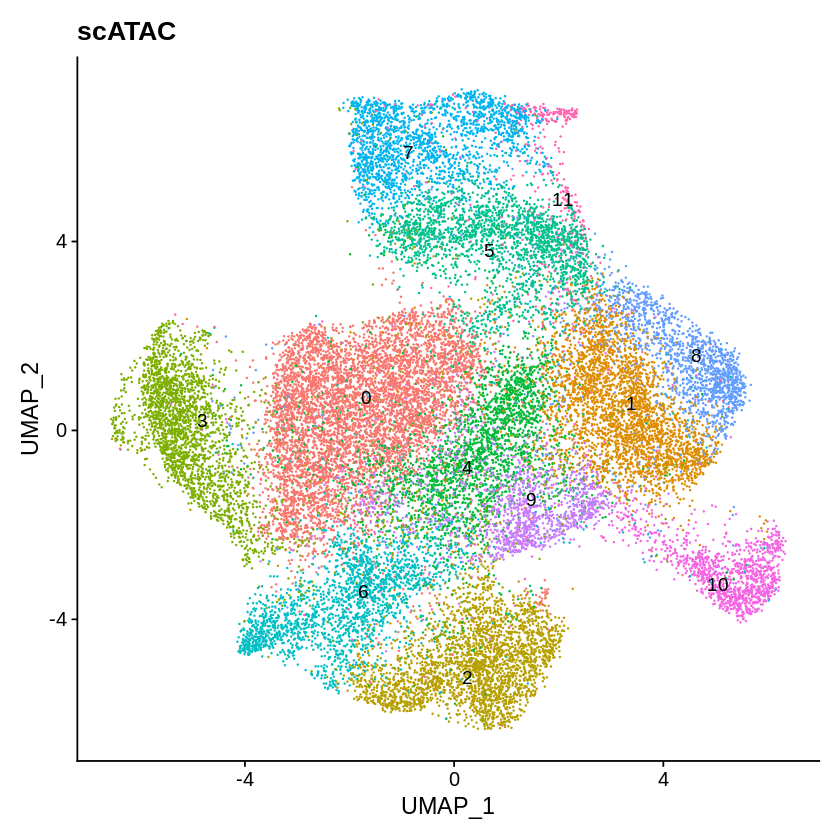

In [9]:
DimPlot(
  object = so,
  group.by = 'seurat_clusters',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC')

Warning message:
"CombinePlots is being deprecated. Plots should now be combined using the patchwork system."


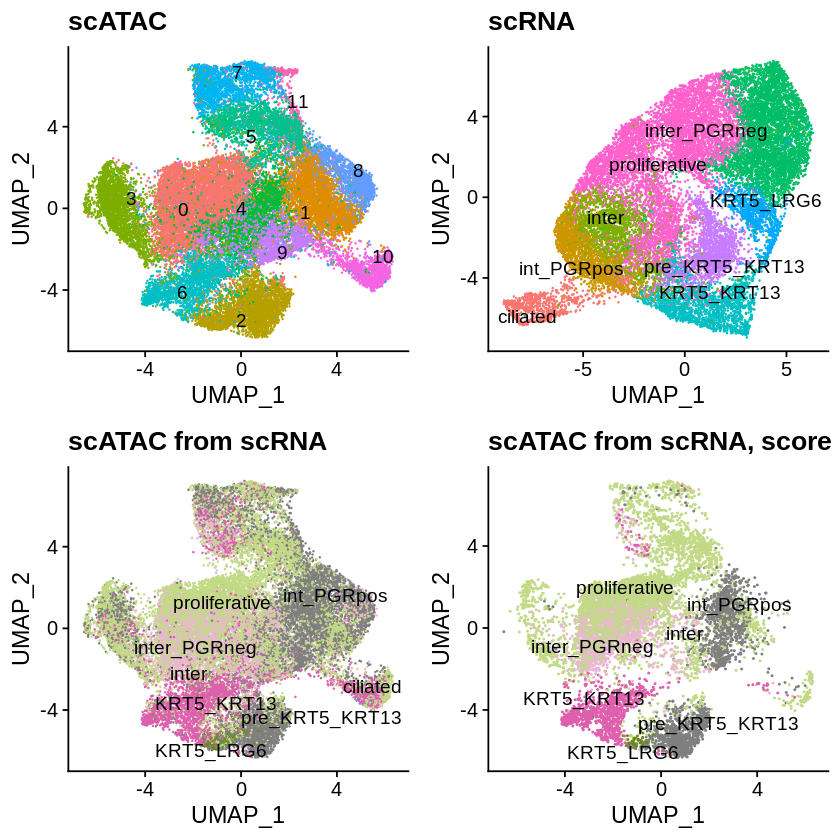

In [27]:
### Visualize UMAPS
# Labels transfer
plot0 <- DimPlot(
  object = so,
  group.by = 'seurat_clusters',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC')

plot1 <- DimPlot(
  object = rna,
  group.by = 'clusters',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scRNA')

plot2 <- DimPlot(cols = colors,
  object = so,
  group.by = 'predicted.id',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC from scRNA')

plot3 <- DimPlot(
  cols = colors,
  object = subset(so, prediction.score.max > 0.5),
  group.by = 'predicted.id',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC from scRNA, score > 0.5')

CombinePlots(list(plot0,plot1,plot2,plot3), ncol = 2)
ggsave(device = 'pdf', file = paste0(outdir, '/general/umap_scRNAseqLabelsTransfer_0.5.pdf'), width = 10, height = 10)

In [ ]:
# Visualize as barplots
# Label transfer
so@meta.data$atac_clusters = so@meta.data$seurat_clusters
so@meta.data$scRNA_imported = so@meta.data$predicted.id
soF = subset(so, prediction.score.max > 0.25)
p1 = ggplot(so@meta.data, aes(x = atac_clusters, fill = scRNA_imported) ) + geom_bar(position = 'fill') + coord_flip() + theme_bw(20)
p2 = ggplot(so@meta.data, aes(fill = atac_clusters, x = scRNA_imported) ) + geom_bar(position = 'fill') + 
    scale_fill_manual(values = c(brewer.pal(n = 12, name = 'Paired'), brewer.pal(n = 8, name = 'Set2'))) +
    coord_flip() + theme_bw(20)
CombinePlots(list(p1,p2), ncol = 2)
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_scRNAseqLabelsTransfer_byATAC.pdf'), width = 20, height = 5)

# Label transfer 0.5
p1 = ggplot(soF@meta.data, aes(x = atac_clusters, fill = scRNA_imported) ) + geom_bar(position = 'fill') + coord_flip() + theme_bw(20)
p2 = ggplot(soF@meta.data, aes(fill = atac_clusters, x = scRNA_imported) ) + geom_bar(position = 'fill') + 
    scale_fill_manual(values = c(brewer.pal(n = 12, name = 'Paired'), brewer.pal(n = 8, name = 'Set2'))) +
    coord_flip() + theme_bw(20)
CombinePlots(list(p1,p2), ncol = 2)
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_scRNAseqLabelsTransfer_byATAC_0.5.pdf'), width = 20, height = 5)

# treatment
p1 = ggplot(so@meta.data, aes(x = atac_clusters, fill = treatment) ) + geom_bar() + theme_bw(20)
p2 = ggplot(so@meta.data, aes(x = treatment, fill = atac_clusters) ) + geom_bar() + theme_bw(20)
p3 = ggplot(soF@meta.data, aes(x = scRNA_imported, fill = treatment) ) + geom_bar() + theme_bw(20) + theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust = 1)) + ggtitle('scATAC from scRNA, score > 0.5')
p4 = ggplot(soF@meta.data, aes(x = treatment, fill = scRNA_imported) ) + geom_bar() + theme_bw(20) + ggtitle('scATAC from scRNA, score > 0.5')
CombinePlots(list(p1,p2,p3,p4), ncol = 2)
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplotCombo_treatment.pdf'), width = 20, height = 10)
p1 + coord_flip()
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_treatment.pdf'), width = 20, height = 10)


# day
so@meta.data$day = factor(so@meta.data$day)
p1 = ggplot(so@meta.data, aes(x = atac_clusters, fill = day) ) + geom_bar() + theme_bw(20)
p2 = ggplot(so@meta.data, aes(x = day, fill = atac_clusters) ) + geom_bar() + theme_bw(20)
p3 = ggplot(soF@meta.data, aes(x = scRNA_imported, fill = day) ) + geom_bar() + theme_bw(20) + theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust = 1)) + ggtitle('scATAC from scRNA, score > 0.5')
p4 = ggplot(soF@meta.data, aes(x = day, fill = scRNA_imported) ) + geom_bar() + theme_bw(20) + ggtitle('scATAC from scRNA, score > 0.5')
CombinePlots(list(p1,p2,p3,p4), ncol = 2)
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplotCombo_day.pdf'), width = 20, height = 10)
p1 + coord_flip()
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_day.pdf'), width = 20, height = 10)

## --------- filled


# treatment
p1 = ggplot(so@meta.data, aes(x = atac_clusters, fill = treatment) ) + geom_bar(position = 'fill') + theme_bw(20)
p2 = ggplot(so@meta.data, aes(x = treatment, fill = atac_clusters) ) + geom_bar(position = 'fill') + theme_bw(20)
p3 = ggplot(soF@meta.data, aes(x = scRNA_imported, fill = treatment) ) + geom_bar(position = 'fill') + theme_bw(20) + theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust = 1)) + ggtitle('scATAC from scRNA, score > 0.5')
p4 = ggplot(soF@meta.data, aes(x = treatment, fill = scRNA_imported) ) + geom_bar(position = 'fill') + theme_bw(20) + ggtitle('scATAC from scRNA, score > 0.5')
CombinePlots(list(p1,p2,p3,p4), ncol = 2)
ggsave(device = 'pdf', file = paste0(outdir, '/general/Fbarplot_treatment.pdf'), width = 20, height = 10)

# day
so@meta.data$day = factor(so@meta.data$day)
soF@meta.data$day = factor(soF@meta.data$day)
p1 = ggplot(so@meta.data, aes(x = atac_clusters, fill = day) ) + geom_bar(position = 'fill') + theme_bw(20)
p2 = ggplot(so@meta.data, aes(x = day, fill = atac_clusters) ) + geom_bar(position = 'fill') + theme_bw(20)
p3 = ggplot(soF@meta.data, aes(x = scRNA_imported, fill = day) ) + geom_bar(position = 'fill') + theme_bw(20) + theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust = 1)) + ggtitle('scATAC from scRNA, score > 0.5')
p4 = ggplot(soF@meta.data, aes(x = day, fill = scRNA_imported) ) + geom_bar(position = 'fill') + theme_bw(20) + ggtitle('scATAC from scRNA, score > 0.5')
CombinePlots(list(p1,p2,p3,p4), ncol = 2)
ggsave(device = 'pdf', file = paste0(outdir, '/general/Fbarplot_day.pdf'), width = 20, height = 10)

# Name/Annotate cell clusters

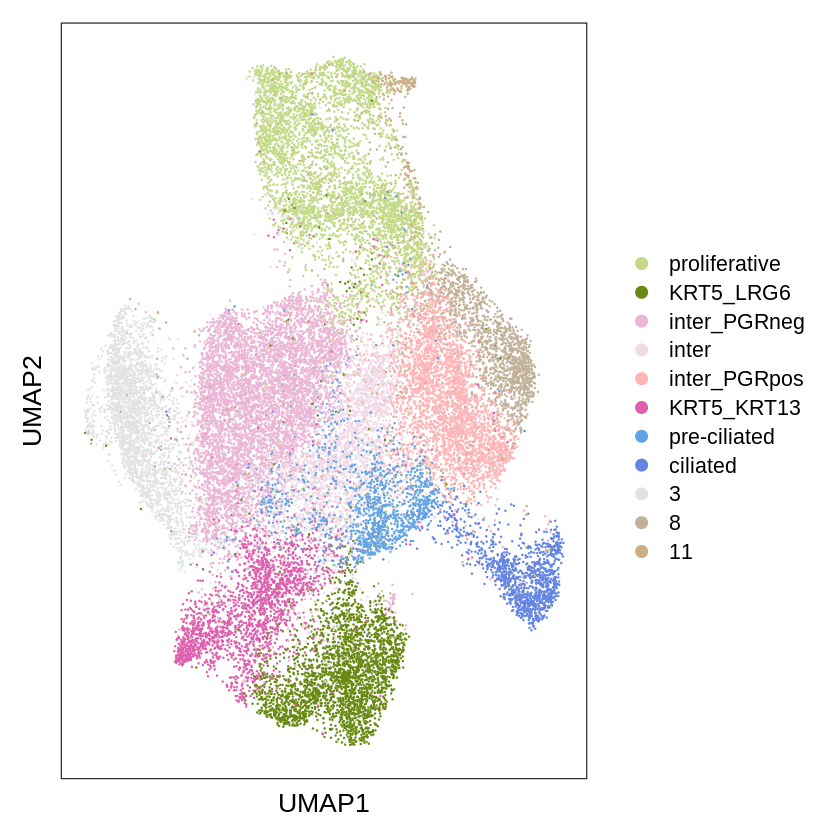

In [21]:
annotation = c('0'='inter_PGRneg',
               '1'='inter_PGRpos',
               '2'='KRT5_LRG6',
               '3'='3',
               '4'='inter',
               '5'='proliferative',
               '6'='KRT5_KRT13',
              '7'='proliferative',
              '8'='8',
              '9'='pre-ciliated',
              '10'='ciliated',
               '11'='11'
)
colors = c('proliferative' = '#c2d986', 
            'KRT5_LRG6' = '#688a12', 
           'inter_PGRneg'= '#ebb5d6', 
           'inter'='#f0dae7',
           'inter_PGRpos'='#ffb5b7',
#            'pre_KRT5_KRT13' = '#aa2aaa',
           'KRT5_KRT13' =  '#de5fad', 
           'pre-ciliated'='#62a4e3',
           'ciliated'= '#6284e3',
            '3'='#e1e3e3',
#             '5'='#bdbdbd',
#             '7'='#d9d0c3',
            '8'='#c2b199',
            '11'='#ccae85')
so@meta.data$celltype = annotation[ as.character(so@meta.data$seurat_clusters) ]
so@meta.data$celltype = factor(so@meta.data$celltype, 
                               levels =  names(colors) )
Idents(so) = so@meta.data$celltype


plot0 <- DimPlot(cols = colors,
  object = so,
  group.by = 'celltype') + xlab('UMAP1') + ylab('UMAP2') +
  theme_bw(16) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
        axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
        axis.text.x = element_blank(), axis.text.y = element_blank())
plot0
ggsave(filename = paste0(outdir, '/general/figure_umap_annotated_celltypes.pdf'), dpi = 300, width = 6, height = 4)

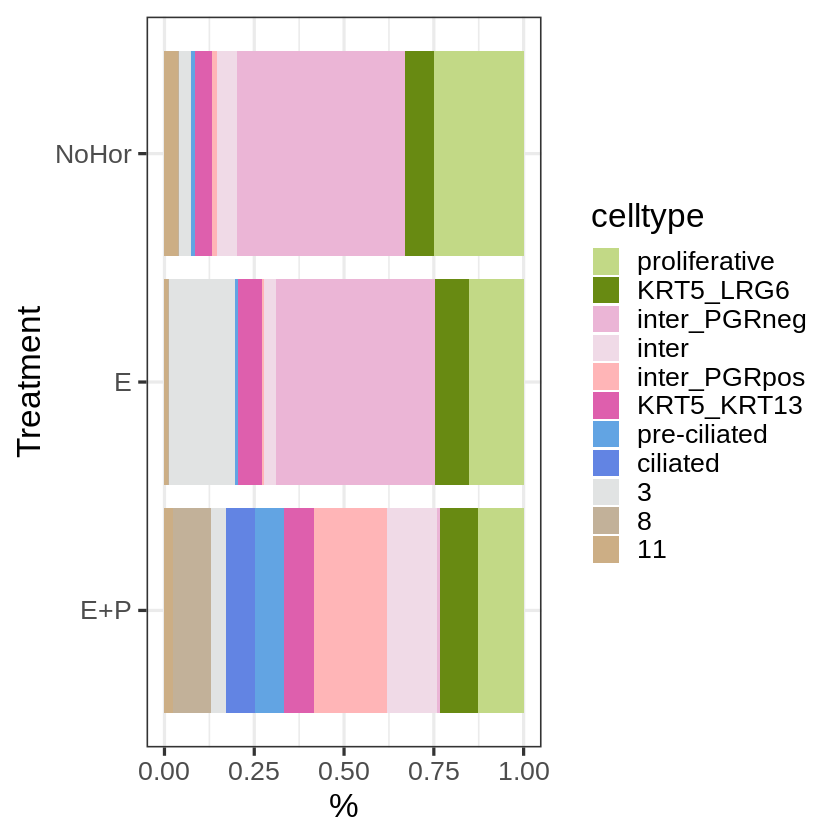

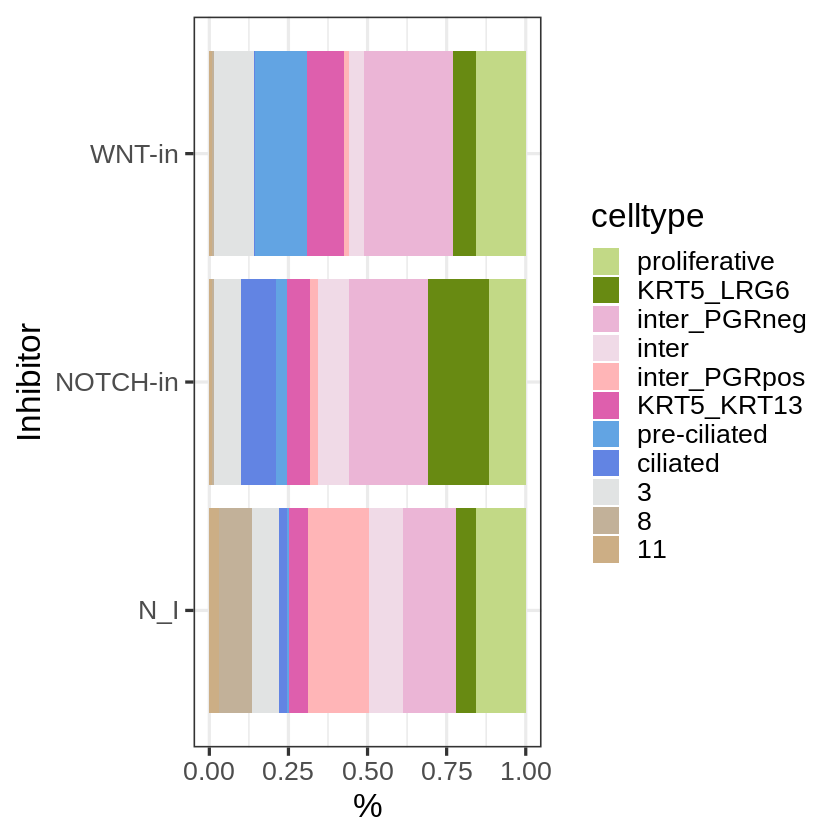

In [23]:
# Visualize as barplots
# treatment
so@meta.data$treatment = factor(so@meta.data$treatment, levels = c('E+P', 'E', 'NoHor'))
so@meta.data$celltype = factor(so@meta.data$celltype, levels = rev(levels(so@meta.data$celltype)) )
p1 = ggplot(so@meta.data, aes(x = treatment , fill = celltype) ) + geom_bar(position = 'fill') + theme_bw(20) + scale_fill_manual(values = colors)
p1 + coord_flip() + xlab('Treatment') + ylab('%')
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_treatment_proportions_clusters.pdf'), width = 12, height = 3)


# Inhibitors
p1 = ggplot(so@meta.data, aes(x = inhibitor , fill = celltype) ) + geom_bar(position = 'fill') + theme_bw(20) + scale_fill_manual(values = rev(colors))
p1 + coord_flip() + xlab('Inhibitor') + ylab('%')
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_inhibitors_proportions_clusters.pdf'), width = 12, height = 3)


In [ ]:
# Visualize as barplots
# treatment
p1 = ggplot(so@meta.data, aes(x = celltype, fill = treatment) ) + geom_bar(position = 'fill') + theme_bw(20)
p1 + coord_flip() + geom_bar(position = 'fill') + theme_bw(20) + scale_fill_brewer(palette = 'Blues')
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_treatment.pdf'), width = 8, height = 4)


so@meta.data$treatment = factor(so@meta.data$treatment, levels = c('E+P', 'E', 'NoHor'))
p1 = ggplot(subset(so, cells = names(Idents(so))[ so@meta.data$celltype   == 'ciliated' ] )@meta.data, aes(x = celltype, fill = treatment) ) + geom_bar(position = 'fill') + theme_bw(20)
p1 + coord_flip() + geom_bar(position = 'fill') + theme_bw(20) + scale_fill_manual(values = brewer.pal(n=3, 'Blues')[2:3]) + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_treatment_ciliated.pdf'), width = 8, height = 1.75)


# day
so@meta.data$day = factor(so@meta.data$day, levels = c(7, 3, 1))
p1 = ggplot(so@meta.data, aes(x = celltype, fill = day) ) + geom_bar(position = 'fill') + theme_bw(20)
p1 + coord_flip() + scale_fill_brewer(palette = 'Blues')
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_day.pdf'), width = 8, height = 4)

In [ ]:
# Visualize as barplots
# treatment
so@meta.data$treatment = factor(so@meta.data$treatment, levels = rev(levels(so@meta.data$treatment)))
p1 = ggplot(so@meta.data, aes(x = celltype, fill = treatment) ) + geom_bar(position = 'fill') + theme_bw(20)
p1 + coord_flip() + geom_bar(position = 'fill') + theme_bw(20) + scale_fill_brewer(palette = 'Blues')
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_treatment.pdf'), width = 8, height = 4)

p1 = ggplot(subset(so, cells = names(Idents(so))[ Idents(so)  == 'KRT5_KRT13' ] )@meta.data, aes(x = celltype, fill = treatment) ) + geom_bar(position = 'fill') + theme_bw(20)
p1 + coord_flip() + geom_bar(position = 'fill') + theme_bw(20) + scale_fill_brewer(palette = 'Blues') + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_treatment_KRT5_KRT13.pdf'), width = 8, height = 1.75)

p1 = ggplot(subset(so, cells = names(Idents(so))[ Idents(so)   == 'ciliated' ] )@meta.data, aes(x = celltype, fill = treatment) ) + geom_bar(position = 'fill') + theme_bw(20)
p1 + coord_flip() + geom_bar(position = 'fill') + theme_bw(20) + scale_fill_brewer(palette = 'Blues') + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_treatment_ciliated.pdf'), width = 8, height = 1.75)

# day
so@meta.data$day = factor(so@meta.data$day, levels = c(7, 3, 1))
p1 = ggplot(so@meta.data, aes(x = celltype, fill = day) ) + geom_bar(position = 'fill') + theme_bw(20)
p1 + coord_flip() + scale_fill_brewer(palette = 'Blues')
ggsave(device = 'pdf', file = paste0(outdir, '/general/barplot_day.pdf'), width = 8, height = 4)

## Save

In [26]:
saveRDS(so,  paste0(outdir, '/data/M3_scRNAseq_labelsTransfer.rds'))

In [25]:
write.csv(so@meta.data, file = paste0(outdir, '/data/barcode_metadata.csv'))

In [4]:
### Load data
# so = readRDS(file = paste0(outdir, '/data/M3_scRNAseq_labelsTransfer.rds'))

## Differentially active GENES

In [ ]:
Idents(so) = so@meta.data$seurat_clusters

DefaultAssay(so) <- 'RNA'
for( cl in levels(Idents(so)) ){
    message('Testing ', cl,'\n')
    da_peaks = FindMarkers(so, ident.1 = cl, test.use = "LR", verbose = F,
                           min.pct = 0.1, 
                           latent.vars = 'nCount_peaks', 
                           logfc.threshold = 0.1)
    write.csv(da_peaks, file = paste0(outdir, '/clusters/DAGenes/', cl, '_LR.csv'))
}